# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [ ]:
Use PCA (or similar, tbd) to identify features or attributes that correspond to the price

In [ ]:
Train and test various models to predict the price of a car based on attributes provided

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.ticker as mtick
import plotly.express as px
from time import time
from scipy import stats


In [5]:
df= pd.read_csv('Downloads/hw_week_11/data/vehicles.csv')


In [6]:
df.info()
# A NUMBER OF INCOMPLETE COLUMNS NEED TO BE ADDRESSED

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [7]:
# Notice 32k $0 prices.  We will remove these as they generally do not reflect the market sales we are targeting.
df['price'].value_counts()


0        32895
6995      3169
7995      3129
9995      2867
8995      2837
         ...  
21298        1
49217        1
63195        1
19709        1
17873        1
Name: price, Length: 15655, dtype: int64

In [8]:
#replace price zeroes with nan and drop
df['price'].value_counts()
df['price'] = df['price'].replace(['0', 0], np.nan)

In [9]:
# assume that cars with NAN drive are fwd so we can retain this data
df['drive']=df['drive'].fillna(value='fwd')
df['drive'].value_counts()


fwd    236084
4wd    131904
rwd     58892
Name: drive, dtype: int64

In [10]:
# we will create a type_median row to make this numerical for analysis, and remap it back later for graphing
df['type'].value_counts()


sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: type, dtype: int64

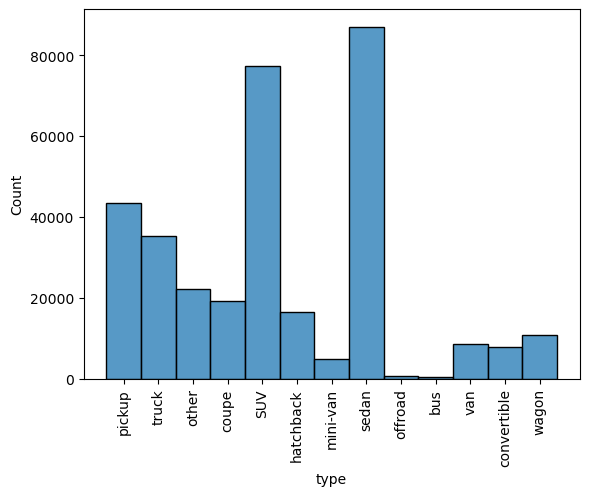

In [11]:
# eyeball histograms to ensure proper distribution
ax=sns.histplot(df['type'])
plt.xticks(rotation=90);
# BUS AND OFFROAD ARE SMALL DATA SETS.  WE SHOULD ENSURE THEY DO NOT CREATE OUTLIERS.


In [12]:
df['model'].value_counts()

f-150                      8009
silverado 1500             5140
1500                       4211
camry                      3135
silverado                  3023
                           ... 
plymouth fury 1               1
f550 box truck delivery       1
duramax 2500hd                1
3 s sport                     1
Paige Glenbrook Touring       1
Name: model, Length: 29649, dtype: int64

In [16]:
# Dropping columns because they are missing too much data:  cylinders, paint_color, size
# Dropping columns because they are irrelevant or redundant id, VIN, title_status,region
# Dropping model because there are too many unique values- will focus on manufacturer + type as a proxy
# Drop NAN
auto=df.drop(['size','paint_color','VIN','cylinders','title_status','region','model','id'],axis=1).dropna()
auto=auto.dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201835 entries, 27 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         201835 non-null  float64
 1   year          201835 non-null  float64
 2   manufacturer  201835 non-null  object 
 3   condition     201835 non-null  object 
 4   fuel          201835 non-null  object 
 5   odometer      201835 non-null  float64
 6   transmission  201835 non-null  object 
 7   drive         201835 non-null  object 
 8   type          201835 non-null  object 
 9   state         201835 non-null  object 
dtypes: float64(3), object(7)
memory usage: 16.9+ MB


In [21]:
#auto=auto.drop('index',axis=1)
auto.reset_index(drop=True)
auto.head()

,price,year,manufacturer,condition,fuel,odometer,transmission,drive,type,state
0,33590.0,2014.0,gmc,good,gas,57923.0,other,fwd,pickup,al
1,22590.0,2010.0,chevrolet,good,gas,71229.0,other,fwd,pickup,al
2,39590.0,2020.0,chevrolet,good,gas,19160.0,other,fwd,pickup,al
3,30990.0,2017.0,toyota,good,gas,41124.0,other,fwd,pickup,al
4,15000.0,2013.0,ford,excellent,gas,128000.0,automatic,rwd,truck,al


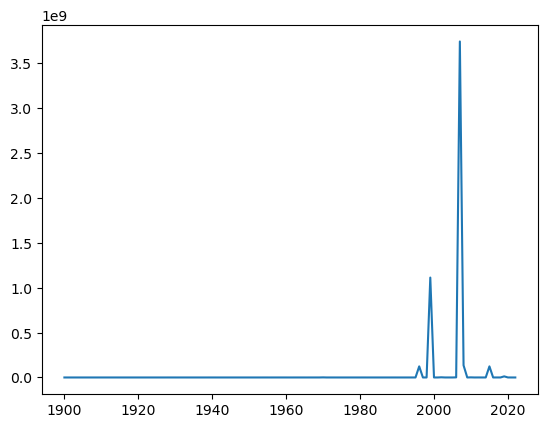

In [22]:
# Chart shows that we need to remove some outliers
plt.plot(auto.groupby('year')['price'].max())


In [226]:
# remove top .05%
auto=auto[auto.price < auto.price.quantile(.999)]

In [227]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196454 entries, 0 to 201733
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         196454 non-null  float64
 1   year          196454 non-null  float64
 2   manufacturer  196454 non-null  object 
 3   condition     196454 non-null  int64  
 4   fuel          196454 non-null  object 
 5   odometer      196454 non-null  float64
 6   transmission  196454 non-null  object 
 7   drive         196454 non-null  object 
 8   type          196454 non-null  object 
 9   state         196454 non-null  object 
 10  manu_median   196454 non-null  float64
 11  type_median   196454 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 19.5+ MB


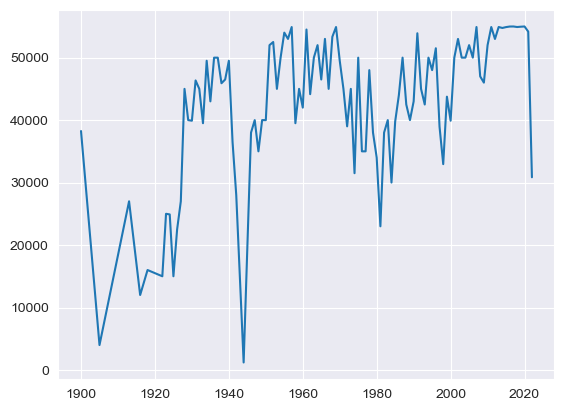

In [228]:
# plot looks more sensible
plt.plot(auto.groupby('year')['price'].max())

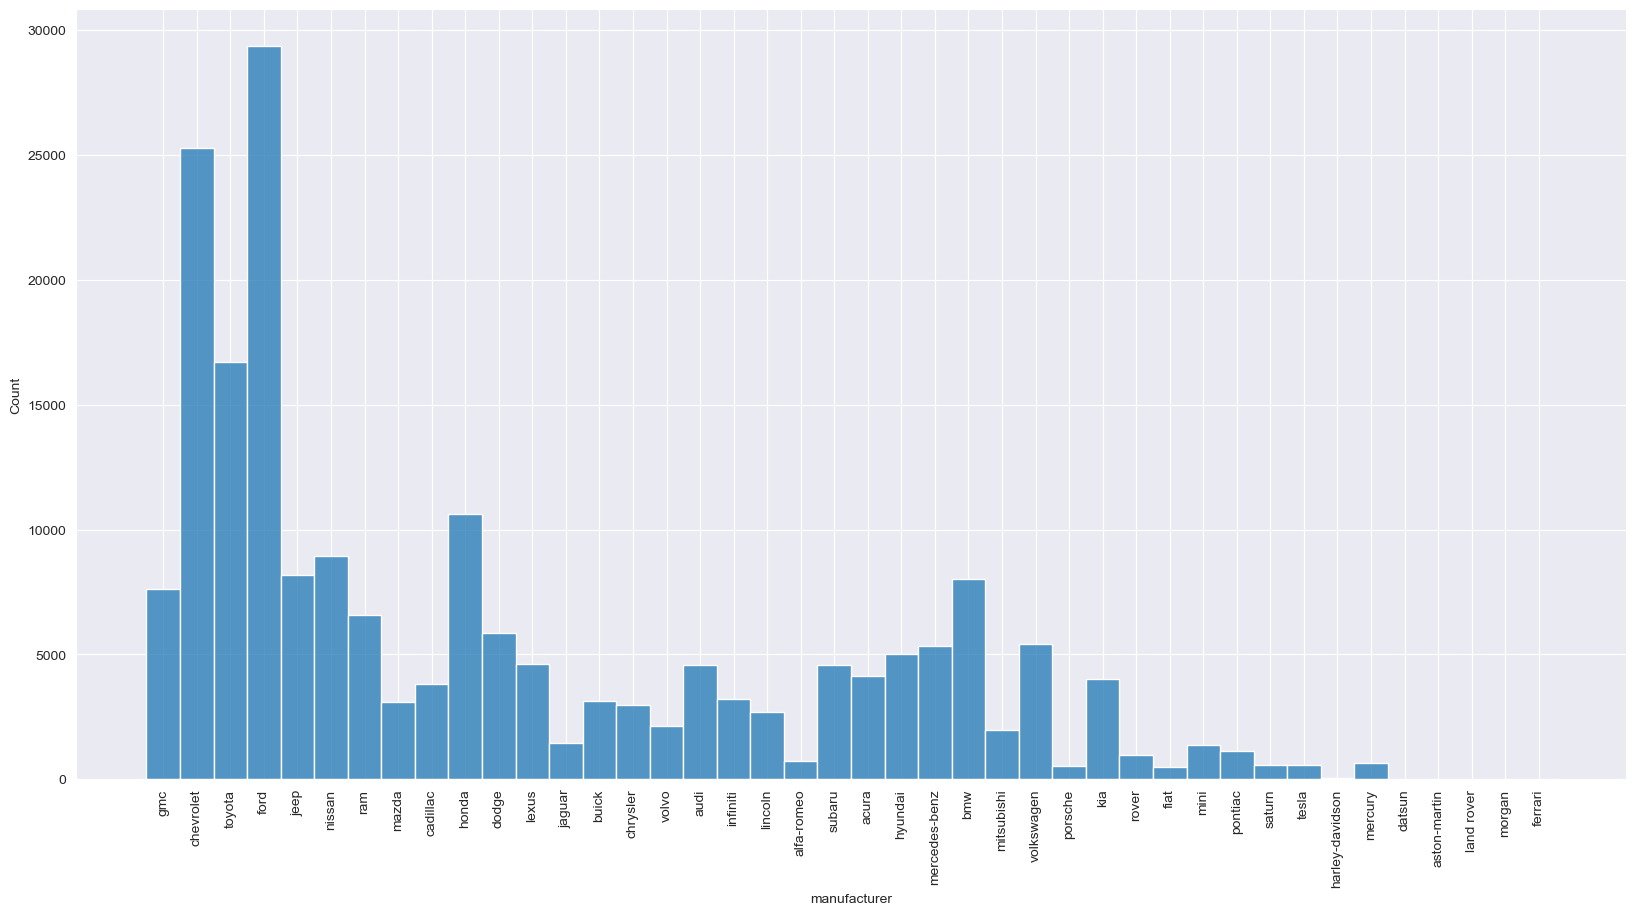

In [229]:
# We want to keep manufacturer and type data, because we know from business team that it affects price.  
# For example, a Ferrari will pretty much always cost more than a Saturn.
# in order to maintain a numeric value, we will convert manufacturer into a manufacturer median.
# Note that we chose median bc there are extreme outliers, including some million dollar Chevy and Fords.
# We will map the manufacturer back based on the median later in the process for presentation.
# We will apply the same method to type, but throw away model because the data has nearly 30k unique values.
fig, ax = plt.subplots(figsize=(20, 10))
ax=sns.histplot(auto['manufacturer'])
plt.xticks(rotation=90)
#sns.set(font_scale=2)
plt.show();

In [230]:
manu_median=auto.groupby('manufacturer')['price'].median()
manu_median=manu_median.sort_values()
print(manu_median)

manufacturer
saturn              4425.0
mercury             4495.0
pontiac             5000.0
land rover          7495.0
chrysler            8500.0
honda               9499.0
nissan             10990.0
hyundai            11495.0
subaru             12000.0
harley-davidson    12500.0
dodge              12995.0
kia                13306.5
mazda              13990.0
toyota             14193.0
ford               15590.0
volkswagen         15590.0
mini               15990.0
datsun             16100.0
fiat               16500.0
chevrolet          16500.0
buick              17040.0
mitsubishi         18950.0
jeep               18980.0
volvo              18990.0
mercedes-benz      19590.0
bmw                20990.0
cadillac           20995.0
lexus              22990.0
acura              23990.0
infiniti           23990.0
gmc                24590.0
lincoln            24590.0
rover              24945.0
porsche            25000.0
ram                25990.0
audi               27990.0
alfa-romeo     

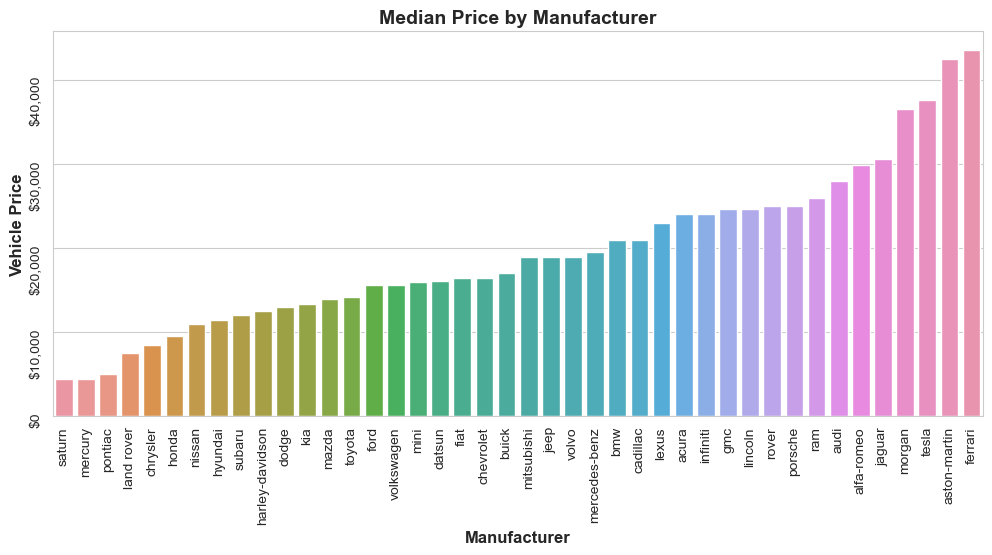

In [231]:
manu_median_plot=manu_median
# plot median price by manufacturer as this is a strong price driver
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axmm = plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")
axmm=sns.barplot(x=manu_median_plot.index,y=manu_median_plot.values)
axmm.set_title("Median Price by Manufacturer",fontdict={'size': 14, 'weight': 'bold'})
axmm.set_xlabel('Manufacturer',fontdict={'size': 12, 'weight': 'bold'})
axmm.set_ylabel('Vehicle Price',fontdict={'size': 12, 'weight': 'bold'})
axmm.yaxis.set_major_formatter(tick) 
#axmm.figure.tight_layout()
axmm.tick_params(rotation=90)
fig.savefig("/var/local/data/auto_price_predictor/images/Median_Price_By_Manu.png");
#plt.xticks(rotation=90);

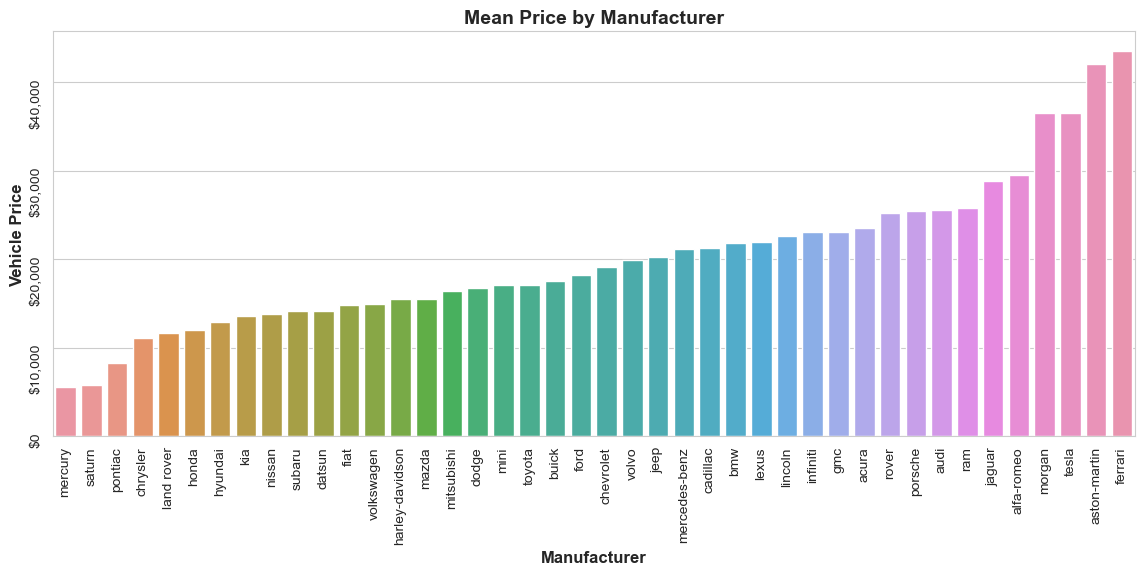

In [232]:
# mean and median look similar, which is a good sign for our dataset
manu_mean=auto.groupby('manufacturer')['price'].mean()
manu_mean=manu_mean.sort_values(ascending=True)
manu_mean_plot=manu_mean
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axmn = plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")
axmn=sns.barplot(x=manu_mean_plot.index,y=manu_mean_plot.values)
axmn.set_title("Mean Price by Manufacturer",fontdict={'size': 14, 'weight': 'bold'})
axmn.set_xlabel('Manufacturer',fontdict={'size': 12, 'weight': 'bold'})
axmn.set_ylabel('Vehicle Price',fontdict={'size': 12, 'weight': 'bold'})
axmn.yaxis.set_major_formatter(tick) 
axmn.figure.tight_layout()
axmn.tick_params(rotation=90);





In [233]:
#Apply similar method to type- calculate a median and add to dataset for regression analysis
type_median=auto.groupby('type')['price'].median()
type_median=type_median.sort_values()
print(type_median)

type
mini-van        6995.0
sedan          10990.0
offroad        12999.0
SUV            13495.0
wagon          13950.0
bus            14995.0
van            14995.0
convertible    14997.0
hatchback      15995.0
truck          19000.0
coupe          20995.0
pickup         27990.0
other          29990.0
Name: price, dtype: float64


In [234]:
auto['manu_median']=np.nan
auto['type_median']=np.nan
auto=auto.reset_index(drop=True)
print(auto.head(3))


     price    year manufacturer  condition fuel  odometer transmission drive  \
0  33590.0  2014.0          gmc          5  gas   57923.0        other   fwd   
1  22590.0  2010.0    chevrolet          5  gas   71229.0        other   fwd   
2  39590.0  2020.0    chevrolet          5  gas   19160.0        other   fwd   

     type state  manu_median  type_median  
0  pickup    al          NaN          NaN  
1  pickup    al          NaN          NaN  
2  pickup    al          NaN          NaN  


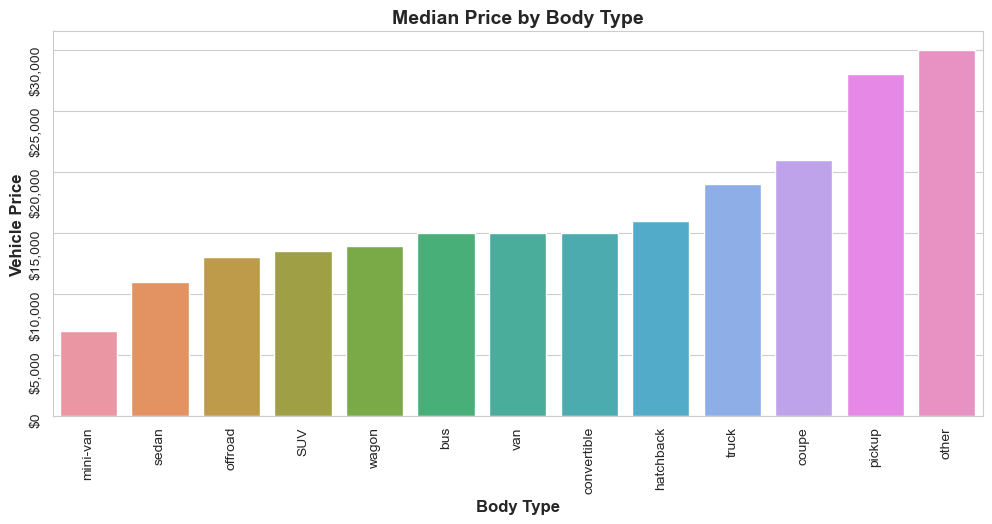

In [235]:
# plot median price by type as this is a strong price driver
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axtm = plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")
axtm=sns.barplot(x=type_median.index,y=type_median.values)

axtm.set_title("Median Price by Body Type",fontdict={'size': 14, 'weight': 'bold'})
axtm.set_xlabel('Body Type',fontdict={'size': 12, 'weight': 'bold'})
axtm.set_ylabel('Vehicle Price',fontdict={'size': 12, 'weight': 'bold'})
axtm.yaxis.set_major_formatter(tick) 
#axmm.figure.tight_layout()
axtm.tick_params(rotation=90)
fig.savefig("/var/local/data/auto_price_predictor/images/Median_Price_By_Type.png");
#plt.xticks(rotation=90);

In [236]:
print(manu_median)

manufacturer
saturn              4425.0
mercury             4495.0
pontiac             5000.0
land rover          7495.0
chrysler            8500.0
honda               9499.0
nissan             10990.0
hyundai            11495.0
subaru             12000.0
harley-davidson    12500.0
dodge              12995.0
kia                13306.5
mazda              13990.0
toyota             14193.0
ford               15590.0
volkswagen         15590.0
mini               15990.0
datsun             16100.0
fiat               16500.0
chevrolet          16500.0
buick              17040.0
mitsubishi         18950.0
jeep               18980.0
volvo              18990.0
mercedes-benz      19590.0
bmw                20990.0
cadillac           20995.0
lexus              22990.0
acura              23990.0
infiniti           23990.0
gmc                24590.0
lincoln            24590.0
rover              24945.0
porsche            25000.0
ram                25990.0
audi               27990.0
alfa-romeo     

In [237]:
# look for duplicates
# we will use this later to map back to manufacturer
print(manu_median.duplicated())

manufacturer
saturn             False
mercury            False
pontiac            False
land rover         False
chrysler           False
honda              False
nissan             False
hyundai            False
subaru             False
harley-davidson    False
dodge              False
kia                False
mazda              False
toyota             False
ford               False
volkswagen          True
mini               False
datsun             False
fiat               False
chevrolet           True
buick              False
mitsubishi         False
jeep               False
volvo              False
mercedes-benz      False
bmw                False
cadillac           False
lexus              False
acura              False
infiniti            True
gmc                False
lincoln             True
rover              False
porsche            False
ram                False
audi               False
alfa-romeo         False
jaguar             False
morgan             False
tesla       

In [269]:
#  Increment duplicate values by one dollar to maintain unique values for mapping data back later
manu_median['volkswagen']=(manu_median['volkswagen']+1)
manu_median['dodge']=(manu_median['dodge']+1)
manu_median['lincoln']=(manu_median['lincoln']+1)
type_median['van']=(type_median['van']+1)
print(manu_median.keys)

<bound method Series.keys of manufacturer
saturn              4425.0
mercury             4495.0
pontiac             5000.0
land rover          7495.0
chrysler            8500.0
honda               9499.0
nissan             10990.0
hyundai            11495.0
subaru             12000.0
harley-davidson    12500.0
dodge              12997.0
kia                13306.5
mazda              13990.0
toyota             14193.0
ford               15590.0
volkswagen         15592.0
mini               15990.0
datsun             16100.0
fiat               16500.0
chevrolet          16500.0
buick              17040.0
mitsubishi         18950.0
jeep               18980.0
volvo              18990.0
mercedes-benz      19590.0
bmw                20990.0
cadillac           20995.0
lexus              22990.0
acura              23990.0
infiniti           23990.0
gmc                24590.0
lincoln            24592.0
rover              24945.0
porsche            25000.0
ram                25990.0
audi         

In [270]:
# check for dupes
print(type_median.duplicated())

type
mini-van       False
sedan          False
offroad        False
SUV            False
wagon          False
bus            False
van            False
convertible    False
hatchback      False
truck          False
coupe          False
pickup         False
other          False
Name: price, dtype: bool


In [271]:
# YOU CAN IGNORE THIS BOX- used to debug data formatting below

#print(len(auto))
#print(auto.head())
#print(auto.columns)
#print(auto.shape[1])
#print(manu_median['ford'])
print(auto.head())
#print(auto.iloc[[2],[8]])
#t=auto['type'].iloc[[1]].to_string(header=False, index=False)
#m=auto['manufacturer'].iloc[[1]].to_string(header=False, index=False)
print(t,m)
#print(int(manu_median[m].tolist()[0]))
print(auto.iloc[[4],[auto.shape[1]-2]])


     price    year manufacturer  condition fuel  odometer transmission drive  \
0  33590.0  2014.0          gmc          5  gas   57923.0        other   fwd   
1  22590.0  2010.0    chevrolet          5  gas   71229.0        other   fwd   
2  39590.0  2020.0    chevrolet          5  gas   19160.0        other   fwd   
3  30990.0  2017.0       toyota          5  gas   41124.0        other   fwd   
4  15000.0  2013.0         ford          7  gas  128000.0    automatic   rwd   

     type state  manu_median  type_median  
0  pickup    al      24590.0        27990  
1  pickup    al      16500.0        27990  
2  pickup    al      16500.0        27990  
3  pickup    al      14193.0        27990  
4   truck    al      15590.0        19000  
coupe bmw
   manu_median
4      15590.0


In [272]:
#update auto dataframe with type and manufacturer median values
# WARNING this take a long time to run!!!!  (get some coffee and look for the 'done!'')

for i in range(0,len(auto)):
#for i in range(0,5):
    t=auto['type'].iloc[[i]].to_string(header=False, index=False)  
    m=auto['manufacturer'].iloc[[i]].to_string(header=False, index=False)
    p=int(manu_median[m])
    q=int(type_median[t])
    #print(p)
    auto.iloc[[i],[auto.shape[1]-2]]=p
    auto.iloc[[i],[auto.shape[1]-1]]=q  
print('done!')


done!


In [242]:
# Convert new columns to int
auto['type_median']=auto['type_median'].astype(int)

In [243]:
# remove lower end outliers
# assume cars that cost less than $500 are outliers or out of scope for targeted resale bc profits are small
auto= auto[auto['price'] > 500]

In [244]:
# numerize condition as ordinal so it can be analyzed
auto['condition'].replace(['new','like new','excellent','good','fair','salvage'],
                        [10,8,7,5,3,1], inplace=True)
print(auto.head())

     price    year manufacturer  condition fuel  odometer transmission drive  \
0  33590.0  2014.0          gmc          5  gas   57923.0        other   fwd   
1  22590.0  2010.0    chevrolet          5  gas   71229.0        other   fwd   
2  39590.0  2020.0    chevrolet          5  gas   19160.0        other   fwd   
3  30990.0  2017.0       toyota          5  gas   41124.0        other   fwd   
4  15000.0  2013.0         ford          7  gas  128000.0    automatic   rwd   

     type state  manu_median  type_median  
0  pickup    al      24590.0        27990  
1  pickup    al      16500.0        27990  
2  pickup    al      16500.0        27990  
3  pickup    al      14193.0        27990  
4   truck    al      15590.0        19000  


In [245]:
auto['condition'].value_counts()

5     103594
7      73143
8      14133
3       4689
10       525
1        370
Name: condition, dtype: int64

<AxesSubplot:xlabel='price', ylabel='Count'>

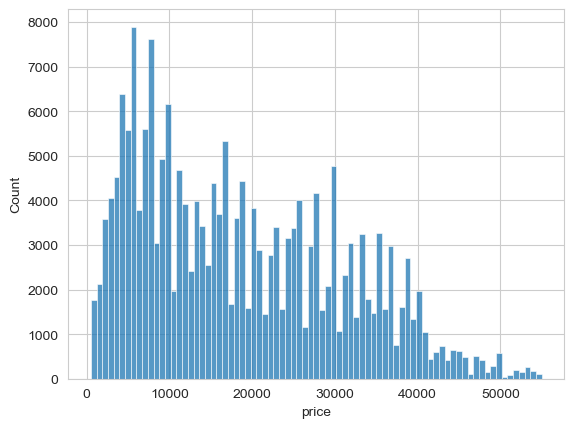

In [246]:
# some negative skew and long positive tail, but this is sensible
sns.histplot(auto['price'])

In [247]:
print(auto['price'].std())

12170.313581431137


In [248]:
auto['price'].min()

501.0

In [249]:
# convert to numerical and standardize data for feature correlation analysis
scaler=StandardScaler()
auto_scaled=auto.select_dtypes(['number'])
scaler.fit(auto_scaled)
auto_scaled=pd.DataFrame(scaler.transform(auto_scaled), columns = auto_scaled.columns)
auto_scaled.rename(columns={'manu_median': 'Manufacturer', 'type_median': 'Body Style'}, inplace=True)
print(auto_scaled.head())


      price      year  condition  odometer  Manufacturer  Body Style
0  1.241358  0.292724  -0.753661 -0.197830      1.445026    1.681024
1  0.337517 -0.152715  -0.753661 -0.120606     -0.104043    1.681024
2  1.734362  0.960882  -0.753661 -0.422797     -0.104043    1.681024
3  1.027723  0.626803  -0.753661 -0.295326     -0.545786    1.681024
4 -0.286134  0.181364   0.887327  0.208874     -0.278289    0.315440


In [250]:
df_corr=abs(auto_scaled.corr()['price'][:])
print('done!')



done!


In [251]:
df_corr=df_corr.sort_values(ascending=True)
df_corr=df_corr.drop('price')
print(df_corr.sort_values(ascending=False))




year            0.454013
Body Style      0.395826
Manufacturer    0.327684
odometer        0.261009
condition       0.139276
Name: price, dtype: float64


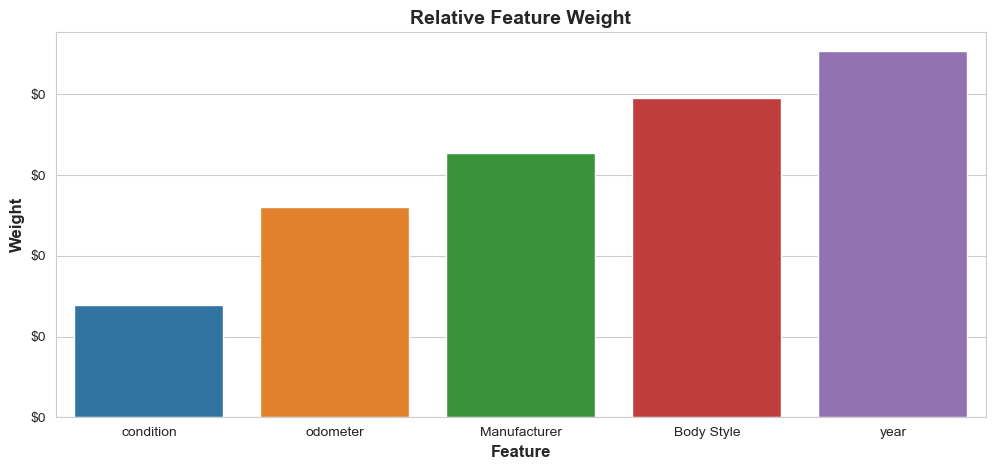

In [252]:

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axrfw = plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")
axrfw=sns.barplot(x=df_corr.index, y=df_corr.values)
axrfw.set_title("Relative Feature Weight",fontdict={'size': 14, 'weight': 'bold'})
axrfw.set_xlabel('Feature',fontdict={'size': 12, 'weight': 'bold'})
axrfw.set_ylabel('Weight',fontdict={'size': 12, 'weight': 'bold'})
axrfw.yaxis.set_major_formatter(tick) 
#axmm.figure.tight_layout()
axtm.tick_params(rotation=90)
fig.savefig("/var/local/data/auto_price_predictor/images/Scaled_Feature_Weight.png");





### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [253]:
#Convert to numerical data only and create groups for train and test
X=auto.select_dtypes(['number']).drop(['price'],axis=1)
y=auto['price']


In [254]:
#save 30% of data to test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size=.3)

In [255]:
# Use a gridsearch to identify best alpha for Ridge on increments
pipe_ridge = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 20, 50, 100.0, 1000.0]}
grid_ridge = GridSearchCV(pipe_ridge, param_grid=param_dict)
grid_ridge.fit(X_train, y_train)
best_alpha_ridge = grid_ridge.best_params_
print(best_alpha_ridge)


{'ridge__alpha': 50}


In [264]:
# Repeat Gridsearch for Lasso regression
pipe_lasso = Pipeline([('scale', StandardScaler()), ('lasso', Lasso())])
param_dict = {'lasso__alpha': [0.001, 0.1, 1.0, 10.0, 20, 50, 100.0, 1000.0]}
grid_lasso = GridSearchCV(pipe_lasso, param_grid=param_dict)
grid_lasso.fit(X_train, y_train)
best_alpha_lasso = grid_lasso.best_params_
print(best_alpha_lasso)

{'lasso__alpha': 1.0}


In [265]:
# Determine betst params for Random Forest with GridSearch
# Here I trim the train dataset to just 5000 to speed processing

X_train_small=X_train.head(5000)
y_train_small=y_train.head(5000)

param_grid = { 
    'n_estimators': [10,50,100],
    'max_features': ['auto','sqrt'],
    'max_depth' : [4,6,8],
#    'criterion' :['gini', 'entropy']
}

rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv= 5)
rf.fit(X_train_small, y_train_small)
print(rf.best_params_)

{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}


In [266]:
#Here I run four regression models and print out the results for comparison

regressors = [
    RandomForestRegressor(max_depth=8,max_features='sqrt',n_estimators=100),
    LinearRegression(),
    Lasso(alpha=10),
    Ridge(alpha=100)
]


#head = 10
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
#   print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean squared error:", int(mean_squared_error(y_test, y_pred)))
    print("\tMean absolute error:", int(mean_absolute_error(y_test, y_pred)))
    print("\tApprox Accuracy:", int(100*(1-(int(mean_absolute_error(y_test, y_pred))/auto.price.mean()))),'%')
    #   print("\tR2 score:", r2_score(y_test, y_pred))

RandomForestRegressor(max_depth=8, max_features='sqrt')
	Training time: 3.758s
	Prediction time: 0.309s
	Mean squared error: 35301022
	Mean absolute error: 4170
	Approx Accuracy: 77 %
LinearRegression()
	Training time: 0.008s
	Prediction time: 0.002s
	Mean squared error: 84438860
	Mean absolute error: 6893
	Approx Accuracy: 62 %
Lasso(alpha=10)
	Training time: 0.007s
	Prediction time: 0.001s
	Mean squared error: 84438701
	Mean absolute error: 6894
	Approx Accuracy: 62 %
Ridge(alpha=100)
	Training time: 0.004s
	Prediction time: 0.001s
	Mean squared error: 84438855
	Mean absolute error: 6893
	Approx Accuracy: 62 %


In [ ]:
# Build best model to extract coefficients
price_predictor=RandomForestRegressor(max_depth=8,max_features='sqrt',n_estimators=100)
price_predictor.fit(X_train,y_train)
print('done!')


In [ ]:
# Build Dataframe to display feature importance according to random forest (best) model:

feature_weights['Feature']=price_predictor.feature_names_in_
feature_weights['Feature Weight']=abs(price_predictor.feature_importances_)
feature_weights=feature_weights.sort_values(by='Feature Weight')
print(feature_weights.head())


In [ ]:
# Formatting in preparation to display with Seaborn
feature_weights.replace("condition","Condition", inplace=True)
feature_weights.replace("manu_median","Manufacturer", inplace=True)
feature_weights.replace("year","Year", inplace=True)
feature_weights.replace("type_median","Body Style", inplace=True)
feature_weights.replace("Odometer","Mileage", inplace=True)
print(feature_weights.head())


In [ ]:
sns.barplot(data=feature_weights,x='Feature',y='Feature Weight').set(title="Relative Feature Weights")
fig.savefig("/var/local/data/auto_price_predictor/images/Relative_Feature_Weights.png") 


In [ ]:
#Creating dictionaries which we will use to rebuild original data frame

#condition dictionary
condition_dict={10:'new',8:'like new',7:'excellent',5:'good',3:'fair',1:'salvage'}

#manufacturer dictionary based on median price
manu_median_dict=manu_median.to_dict()
manu_median_dict = {y: x for x, y in manu_median_dict.items()}
print(manu_median_dict)

# type dictionary based on type median price
type_median_dict=type_median.to_dict()
type_median_dict = {y: x for x, y in type_median_dict.items()}
print(type_median_dict)

In [ ]:
df_final=auto.select_dtypes(['number'])

In [ ]:
df_final["manufacturer"] = df_final["manu_median"].map(manu_median_dict)
df_final["type"] = df_final["type_median"].map(type_median_dict)
df_final["car_condition"] = df_final["condition"].map(condition_dict)
print(df_final.head())
    

In [ ]:
#Convert Odometer into categorical mileage column for final presentation and analysis
def getmilage(x):
    if x >= 0 and x <= 10_000:
        return "brand new"
    if x > 10_000 and x <= 50_000:
        return "low"
    if x > 50_000 and x <= 100_000:
        return "moderate"
    if x > 100_000 and x <= 200_000:
        return "very high"
    if x > 200_000 :
        return "X-tremely high"
    else:
        return 'N/A'

df_final['mileage']=df_final.apply(lambda x: getmilage(x['odometer']),axis=1)


In [ ]:
#Convert Year into categorical vintage column for presentation and analysis
def getdecade(x):
    if x >= 1920 and x <= 1959:
        return "Artisan Antique"
    if x >= 1960 and x <= 1980:
        return "Classic"
    if x > 1980 and x <= 1998:
        return "Modern Antique"
    if x > 1998 and x <= 2013:
        return "Very Old"
    if x > 2013 and x <= 2018:
        return "Old"
    if x > 2018 and x <= 2021:
        return "Modern"
    if x > 2021 :
        return "New"
    else:
        return 'N/A'

df_final['vintage']=df_final.apply(lambda x: getdecade(x['year']),axis=1)

In [ ]:
print(df_final['vintage'].value_counts())
#df_final.head()

In [ ]:
print(df_final.head())

In [ ]:
# Create price type data frame- this is required to efficiently sort values for Seaborn plot
price_type=(df_final.groupby('type')['price'].median())
print(price_type.sort_values(ascending=True))
df_pt=pd.DataFrame(price_type)
df_pt.reset_index(inplace=True)
df_pt=df_pt.sort_values(by='price')
print(df_pt.head())

In [ ]:
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axpbt = plt.figure(figsize=(12, 5))

axpbt=sns.barplot(data=df_pt,x='type',y='price',ci=None)
plt.xticks(rotation=90)
sns.set_style("whitegrid")
axpbt.set_title("Median Price by Body Type",fontdict={'size': 14, 'weight': 'bold'})
axpbt.set_xlabel('Body Type',fontdict={'size': 12, 'weight': 'bold'})
axpbt.set_ylabel('Vehicle Price',fontdict={'size': 12, 'weight': 'bold'})
axpbt.yaxis.set_major_formatter(tick) 
#axmm.figure.tight_layout()
axtm.tick_params(rotation=90)
fig.savefig("/var/local/data/auto_price_predictor/images/PricebyBodyType.png");


In [ ]:
# Create price-manufacturer data frame- this is required to efficiently sort values for Seaborn plot
price_manu=(df_final.groupby('manufacturer')['price'].median())
print(price_manu.sort_values(ascending=True))
df_pm=pd.DataFrame(price_manu)
#drop ferrari bc it throws off scale
df_pm=df_pm.query("manufacturer != 'ferrari'")
df_pm.reset_index(inplace=True)
df_pm=df_pm.sort_values(by='price')
print(df_pm.head())

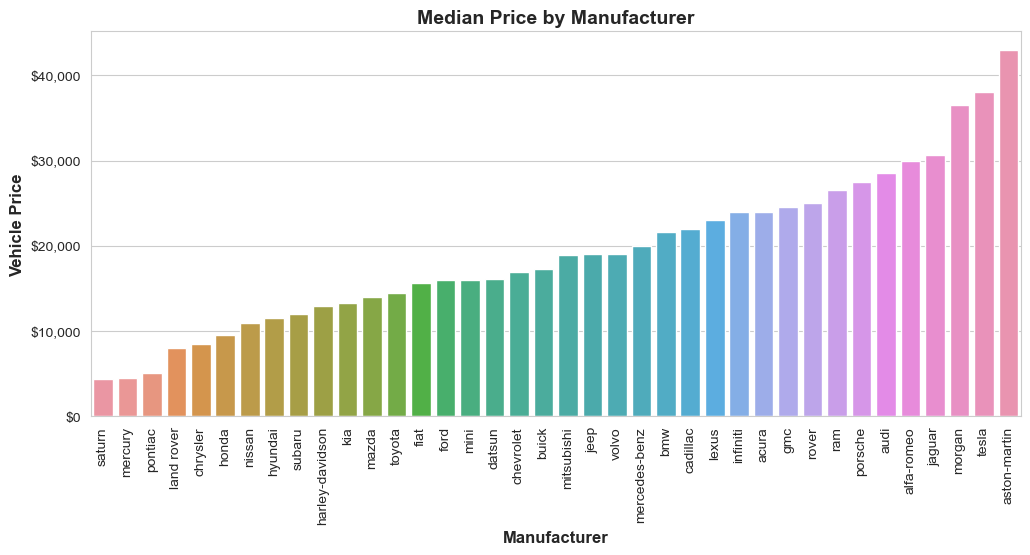

In [261]:
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
axpbt = plt.figure(figsize=(12, 5))

axpbt=sns.barplot(data=df_pm,x='manufacturer',y='price',ci=None)
plt.xticks(rotation=90)
sns.set_style("whitegrid")
axpbt.set_title("Median Price by Manufacturer",fontdict={'size': 14, 'weight': 'bold'})
axpbt.set_xlabel('Manufacturer',fontdict={'size': 12, 'weight': 'bold'})
axpbt.set_ylabel('Vehicle Price',fontdict={'size': 12, 'weight': 'bold'})
axpbt.yaxis.set_major_formatter(tick) 
#axmm.figure.tight_layout()
axtm.tick_params(rotation=90)
fig.savefig("/var/local/data/auto_price_predictor/images/PricebyManu.png");

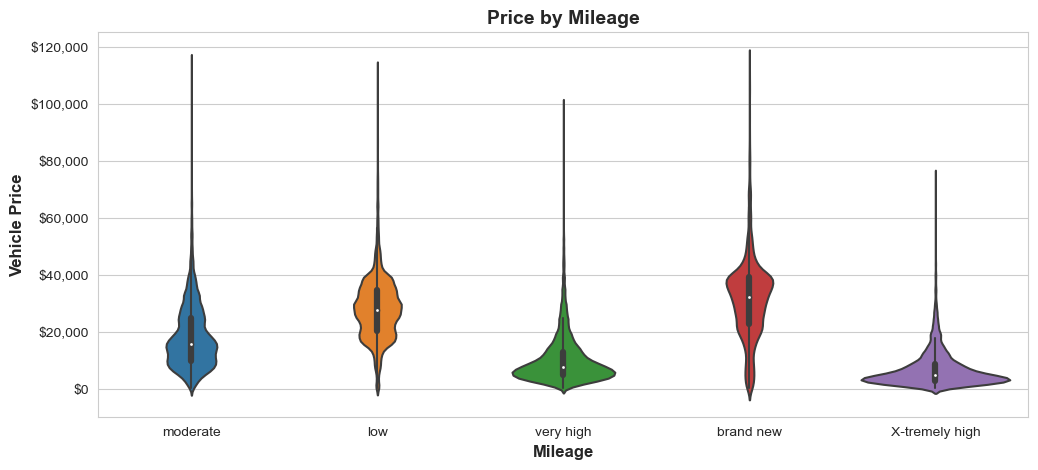

In [262]:
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax10 = plt.figure(figsize=(12, 5))
ax10=sns.violinplot(data=df_final,x='mileage',y='price') 
sns.set_style("darkgrid")
ax10.set_title("Price by Mileage",fontdict={'size': 14, 'weight': 'bold'})
ax10.set_xlabel('Mileage',fontdict={'size': 12, 'weight': 'bold'})
ax10.set_ylabel('Vehicle Price',fontdict={'size': 12, 'weight': 'bold'})
ax10.yaxis.set_major_formatter(tick) 
#axmm.figure.tight_layout()
#ax10.tick_params(rotation=90);

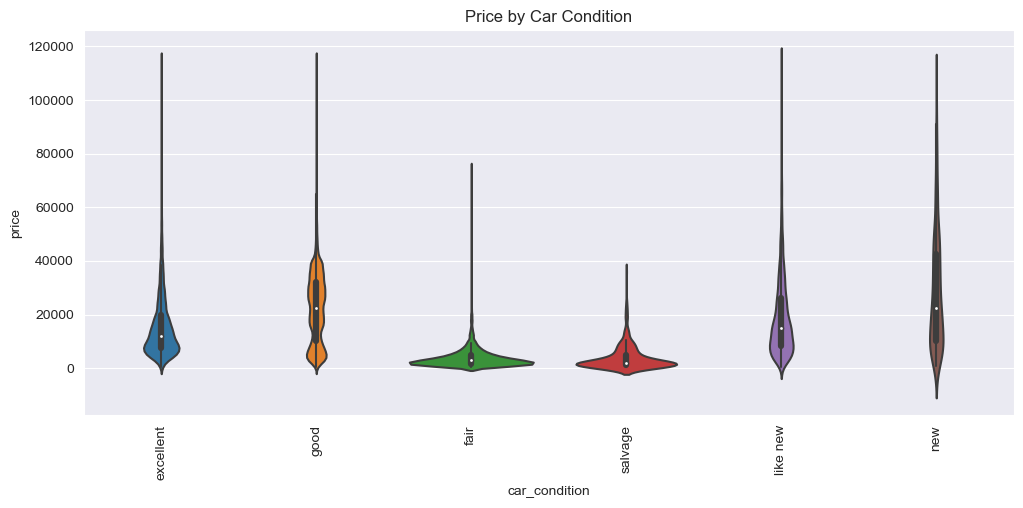

In [263]:
ax11 = plt.figure(figsize=(12, 5))
ax11=sns.violinplot(data=df_final,x='car_condition',y='price').set(title='Price by Car Condition')   
plt.xticks(rotation=90);

In [ ]:
ax12 = plt.figure(figsize=(12, 5))
ax12=sns.violinplot(data=df_final,x='type',y='price').set(title='Price by Body Style')   
plt.xticks(rotation=90);

In [ ]:
ax12 = plt.figure(figsize=(12, 5))
ax12=sns.violinplot(data=df_final,x='mileage',y='price').set(title='Price by Mileage')   
plt.xticks(rotation=90);

In [ ]:
ax14 = plt.figure(figsize=(12, 5))
ax14=sns.violinplot(data=df_final,x='vintage',y='price').set(title='Price by Vintage')   
plt.xticks(rotation=90);

In [ ]:
cohort=df_final.query()

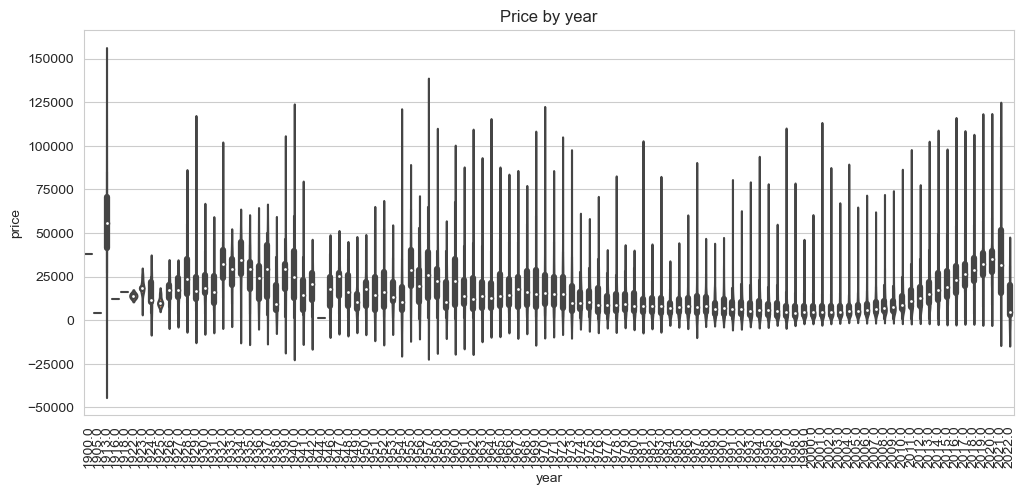

In [257]:
ax13 = plt.figure(figsize=(12, 5))
ax13=sns.violinplot(data=df_final,x='year',y='price').set(title='Price by year')   
plt.xticks(rotation=90);

In [258]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198665 entries, 193836 to 158823
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          198665 non-null  float64
 1   year           198665 non-null  float64
 2   condition      198665 non-null  int64  
 3   odometer       198665 non-null  float64
 4   manu_median    198665 non-null  float64
 5   type_median    198665 non-null  int64  
 6   manufacturer   198665 non-null  object 
 7   type           198665 non-null  object 
 8   car_condition  198665 non-null  object 
 9   mileage        198665 non-null  object 
 10  vintage        198665 non-null  object 
dtypes: float64(4), int64(2), object(5)
memory usage: 18.2+ MB


In [259]:
price_manu_med=df_final.groupby('manufacturer').price.median()
price_manu_mean=df_final.groupby('manufacturer').price.mean()
price_manu_mean=price_manu_mean.sort_values(ascending=False)
price_manu_med=price_manu_med.sort_values(ascending=False)
print(price_manu_med)
print(price_manu_mean)

manufacturer
ferrari            98900.0
aston-martin       42995.0
tesla              37990.0
morgan             36500.0
jaguar             30590.0
alfa-romeo         29900.0
audi               28590.0
porsche            27500.0
ram                26590.0
rover              24990.0
gmc                24590.0
infiniti           23990.0
acura              23990.0
lexus              22990.0
cadillac           21990.0
bmw                21590.0
mercedes-benz      19990.0
jeep               18990.0
volvo              18990.0
mitsubishi         18950.0
buick              17300.0
chevrolet          16950.0
datsun             16100.0
mini               15990.0
ford               15990.0
fiat               15590.0
toyota             14500.0
mazda              13990.0
kia                13325.0
harley-davidson    12995.0
subaru             12000.0
hyundai            11495.0
nissan             10990.0
honda               9500.0
chrysler            8500.0
land rover          7995.0
pontiac        

In [260]:
manu_result=df_final.groupby('car_condition')['relative error'].mean()
print(manu_result)

KeyError: 'Column not found: relative error'

In [1020]:
volvo_cohort=df_final.query('manufacturer == "volvo"')
volvo_cohort['year']=volvo_cohort['year'].astype(int)
print(volvo_cohort.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 18528 to 40535
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             277 non-null    int64  
 1   condition        277 non-null    int64  
 2   odometer         277 non-null    float64
 3   manu_median      277 non-null    float64
 4   type_median      277 non-null    int64  
 5   price            277 non-null    float64
 6   predicted_price  277 non-null    float64
 7   absolute error   277 non-null    float64
 8   relative error   277 non-null    float64
 9   manufacturer     277 non-null    object 
 10  type             277 non-null    object 
 11  car_condition    277 non-null    object 
dtypes: float64(6), int64(3), object(3)
memory usage: 28.1+ KB
None


/var/folders/nc/d0qq985n7zv3k6s5tl41yz4c0000gn/T/ipykernel_2352/547935857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volvo_cohort['year']=volvo_cohort['year'].astype(int)


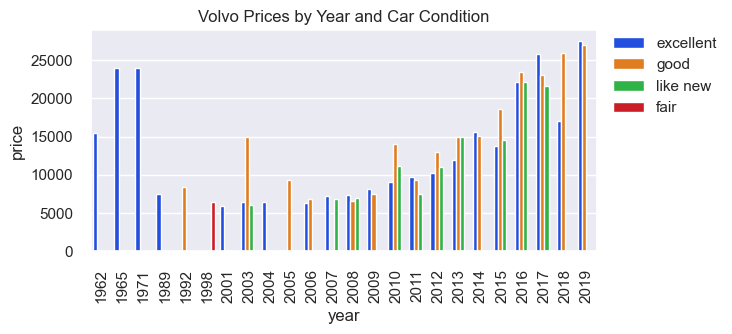

In [1021]:
ax3=sns.barplot(data=volvo_cohort,x='year',y='price',hue='car_condition',ci=None).set(title='Volvo Prices by Year and Car Condition')
plt.xticks(rotation=90)
sns.set_palette("bright") 
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.savefig("/var/local/data/auto_price_predictor/images/volvo_price_x_year_condition.png") 
plt.show();

In [1098]:
ford_cohort=df_final.query('manufacturer == "ford"')
ford_cohort['odometer_sqrt']=np.sqrt(ford_cohort['odometer']).round(0)
print(ford_cohort.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5138 entries, 96027 to 94053
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             5138 non-null   float64
 1   condition        5138 non-null   int64  
 2   odometer         5138 non-null   float64
 3   manu_median      5138 non-null   float64
 4   type_median      5138 non-null   int64  
 5   price            5138 non-null   float64
 6   predicted_price  5138 non-null   float64
 7   absolute error   5138 non-null   float64
 8   relative error   5138 non-null   float64
 9   manufacturer     5138 non-null   object 
 10  type             5138 non-null   object 
 11  car_condition    5138 non-null   object 
 12  mileage          5138 non-null   object 
 13  odometer_sqrt    5138 non-null   float64
dtypes: float64(8), int64(2), object(4)
memory usage: 602.1+ KB
None


/var/folders/nc/d0qq985n7zv3k6s5tl41yz4c0000gn/T/ipykernel_2352/3371719853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ford_cohort['odometer_sqrt']=np.sqrt(ford_cohort['odometer']).round(0)


In [1095]:
#df['hour'] = df.apply(lambda x: find_hour(x['Dates']), axis=1)
def getmilage(x):
    if x >= 0 and x <= 10_000:
        return "brand new"
    if x > 10_000 and x <= 50_000:
        return "low"
    if x > 50_000 and x <= 100_000:
        return "moderate"
    if x > 100_000 and x <= 200_000:
        return "very high"
    if x > 200_000 :
        return "X-tremely high"
    else:
        return 'N/A'

df_final['mileage']=df_final.apply(lambda x: getmilage(x['odometer']),axis=1)


In [1077]:
print(df_final['mileage'].value_counts())
print(df_final.query('mileage == "N/A"'))

high        12997
moderate    10648
low          8638
new          1498
extreme      1313
Name: mileage, dtype: int64
Empty DataFrame
Columns: [year, condition, odometer, manu_median, type_median, price, predicted_price, absolute error, relative error, manufacturer, type, car_condition, mileage]
Index: []


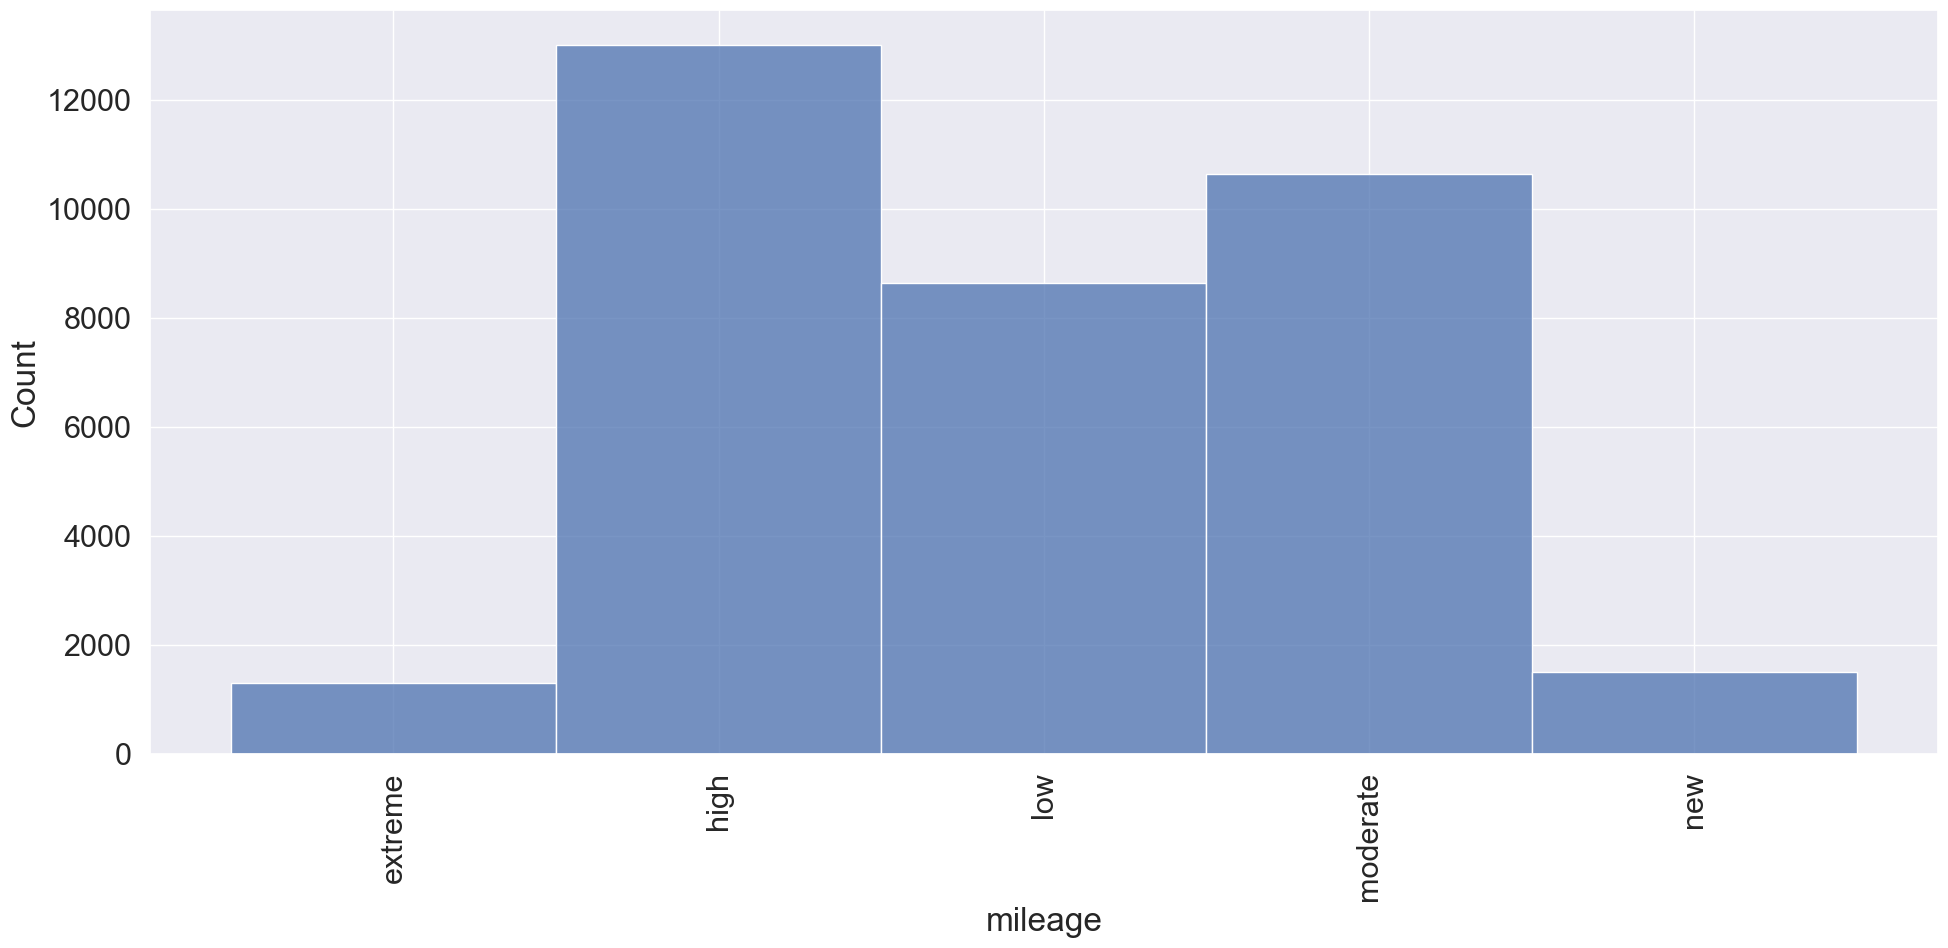

In [1076]:
fig, ax = plt.subplots(figsize=(20, 10))
ax=sns.histplot(df_final['mileage'])
plt.xticks(rotation=90)
sns.set(font_scale=2)
plt.show();

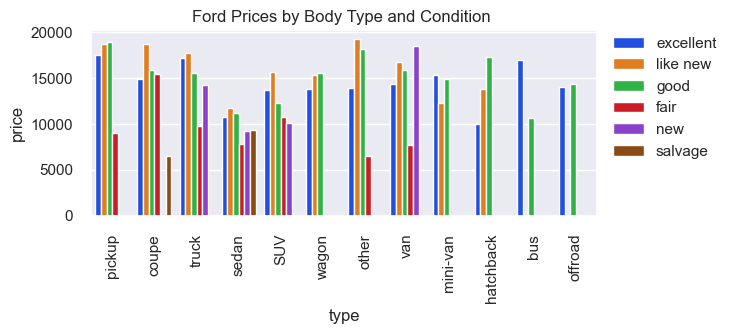

In [1064]:
ax5=sns.barplot(data=ford_cohort,x='type',y='price',hue='car_condition',ci=None).set(title="Ford Prices by Body Type and Condition ")
sns.set_style("darkgrid")
plt.xticks(rotation=90)
#for ind, label in enumerate(ax4.get_xticklabels()):
#    if ind % 10 == 0:  # every 10th label is kept
#        label.set_visible(True)
#    else:
#        label.set_visible(False)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.savefig("/var/local/data/auto_price_predictor/images/ford_price_x_type_condition.png") 
#plt.show();

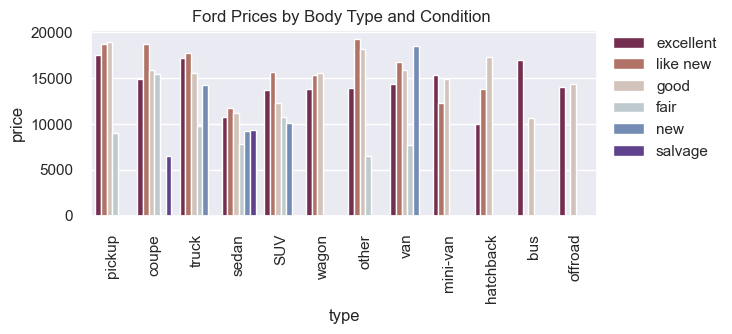

In [1004]:
ax4=sns.barplot(data=ford_cohort,x='type',y='price',hue='car_condition',ci=None).set(title="Ford Prices by Body Type and Condition ")
sns.set_style("darkgrid")
plt.xticks(rotation=90)
#for ind, label in enumerate(ax4.get_xticklabels()):
#    if ind % 10 == 0:  # every 10th label is kept
#        label.set_visible(True)
#    else:
#        label.set_visible(False)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.savefig("/var/local/data/auto_price_predictor/images/ford_price_x_type_condition.png") 
#plt.show();

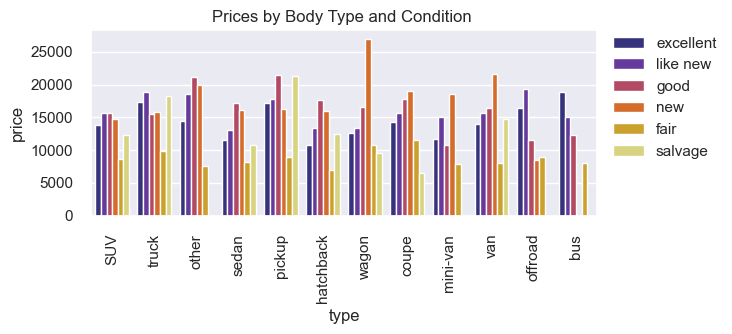

In [1116]:
ax6=sns.barplot(data=df_final,x='type',y='price',hue='car_condition',ci=None,palette="CMRmap").set(title="Prices by Body Type and Condition ")
#sns.set_style("winter")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
fig.savefig("/var/local/data/auto_price_predictor/images/all_models_price_x_type_condition.png") 
#plt.show();

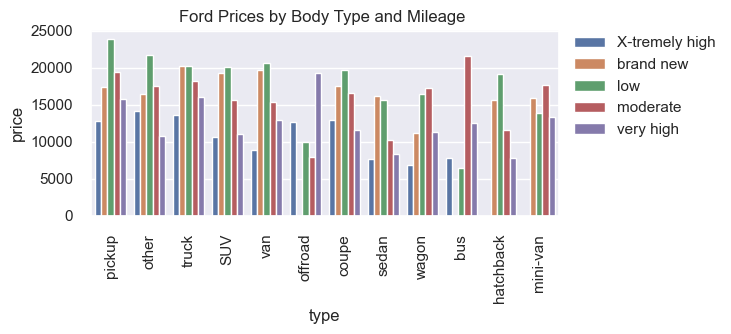

In [1117]:
ford_cohort=ford_cohort.sort_values(by='mileage')
ax4=sns.barplot(data=ford_cohort,x='type',y='price',hue='mileage',ci=None).set(title="Ford Prices by Body Type and Mileage ")
sns.set_style("darkgrid")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.set(font_scale=1)
fig.savefig("/var/local/data/auto_price_predictor/images/ford_price_x_type_mileage.png") 
#plt.show();

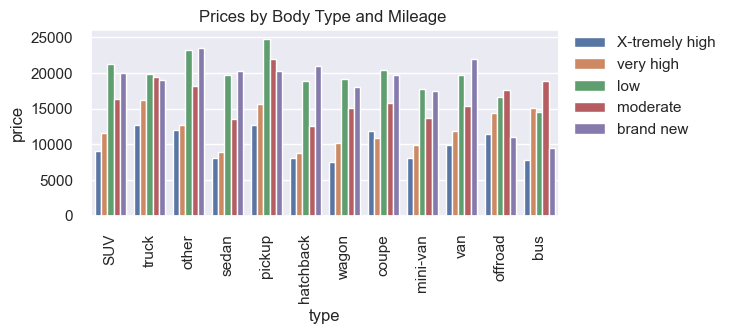

In [1118]:
ax5=sns.barplot(data=df_final,x='type',y='price',hue='mileage',ci=None).set(title="Prices by Body Type and Mileage ")
sns.set_style("darkgrid")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.set(font_scale=1)
fig.savefig("/var/local/data/auto_price_predictor/images/all_models_price_x_type_mileage.png") 
#plt.show();

In [1104]:
result=pd.DataFrame(columns=['price','prediction'])
result['price']=yL_test
result['prediction']=yL_pred
result['absolute error']=abs((result['price']-result['prediction']))
result['relative error']=(100*(abs((result['absolute error']/result['price']))))
result['relative error']=pd.to_numeric(result['relative error'], downcast='integer')
result = result.astype({"absolute error":"int","relative error":"int","prediction":"int","price":"int"})
result=result.sort_values(by='price',ascending=True)
result.reset_index(inplace=True)
print(result.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35094 entries, 0 to 35093
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   index           35094 non-null  int64
 1   price           35094 non-null  int64
 2   prediction      35094 non-null  int64
 3   absolute error  35094 non-null  int64
 4   relative error  35094 non-null  int64
dtypes: int64(5)
memory usage: 1.3 MB
None


In [737]:
print(result.head(3))
print(int(result['relative error'].mean()))

   price  prediction  absolute error  relative error
0   5925        9601            3676              62
1   5927        9875            3948              66
2   5931        7976            2045              34
21


In [677]:
result_group=result.groupby('price')['relative error'].mean()

In [678]:
print(result_group)

price
5925.0     62.043660
5927.0     66.612043
5931.0     34.488032
5944.0     64.731782
5950.0     55.136409
             ...    
28000.0    32.762903
28039.0    22.325692
28040.0    22.228854
28059.0    19.456769
28150.0    38.484605
Name: relative error, Length: 2542, dtype: float64


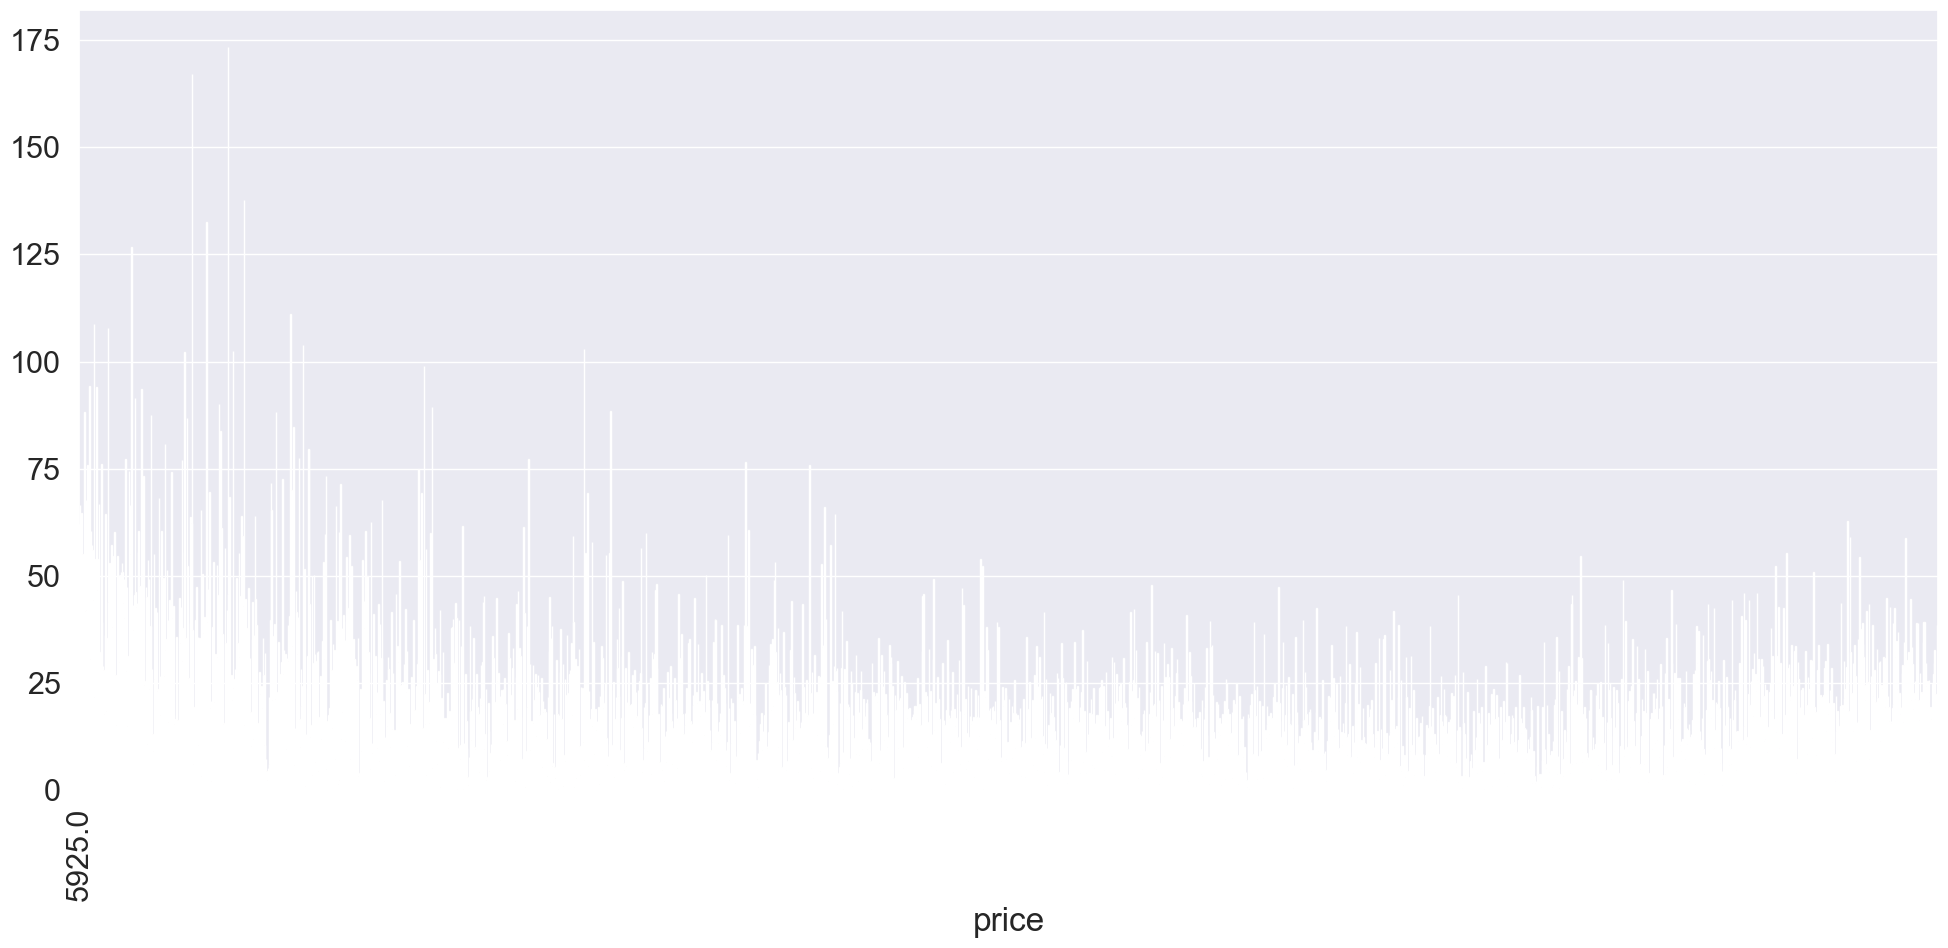

In [683]:
ax = plt.subplots(figsize=(20, 10))
ax=sns.barplot(x=result_group.index,y=result_group.values)
plt.xticks(rotation=90)
sns.set(font_scale=2)
new_ticks = [i.get_text() for i in ax.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 10000), new_ticks[::100000])
plt.show();

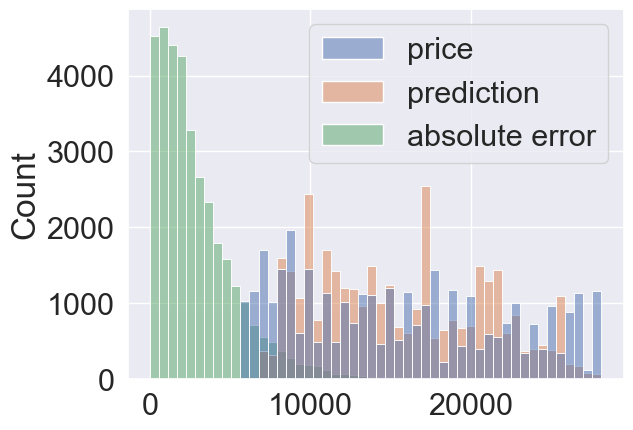

In [638]:
ax=sns.histplot(result)
#ax.set_xlim(1, 100000)
#plt.show()

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

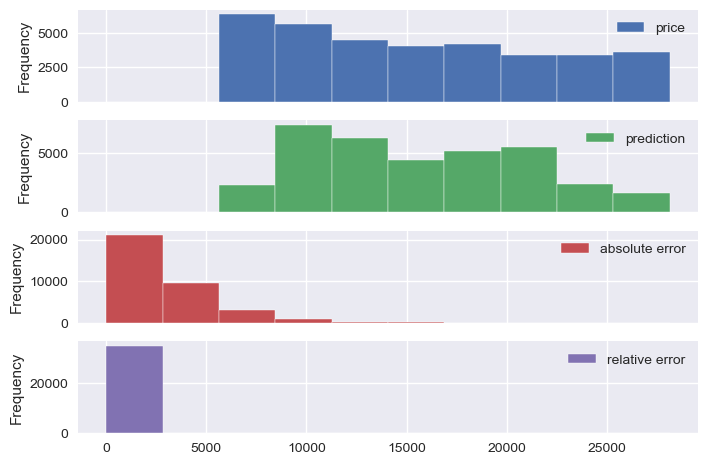

In [664]:
plt.style.use('seaborn')

# Plotting as desired
result.plot.hist(subplots=True, legend=True)

In [798]:
df_final.info()
#test=(.0001*df_final['odometer']).astype(int)
#print(test.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35094 entries, 103095 to 79246
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             35094 non-null  float64
 1   condition        35094 non-null  int64  
 2   odometer         35094 non-null  float64
 3   manu_median      35094 non-null  float64
 4   type_median      35094 non-null  int64  
 5   price            35094 non-null  float64
 6   predicted_price  35094 non-null  float64
 7   absolute error   35094 non-null  float64
 8   relative error   35094 non-null  float64
 9   manufacturer     33142 non-null  object 
 10  type             35094 non-null  object 
 11  car_condition    35094 non-null  object 
dtypes: float64(7), int64(2), object(3)
memory usage: 3.5+ MB


In [788]:
df_medians=pd.DataFrame()
df_medians['condition']=df_final.groupby('car_condition').price.median()
df_medians['manufacturer']=df_final.groupby('manufacturer').price.median()
df_medians['type']=df_final.groupby('type').price.median()
#df_medians['odometer']=df_final.groupby('odemeter').price.median()
print(df_medians.head())

               condition  manufacturer  type
car_condition                               
excellent        12500.0           NaN   NaN
fair              7995.0           NaN   NaN
good             17990.0           NaN   NaN
like new         13999.0           NaN   NaN
new              16600.0           NaN   NaN


In [ ]:
sns.barplot(data=test,x=)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.